# Setup

In [52]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import os
import sys
import pickle

sys.path.append('../ECCOv4-py')
sys.path.append('..')

import ecco_v4_py as ecco

from scripts.basin_masks import get_basin_solodoch
from streamfunction_ecco.streamfunction_ecco_utils import calc_meridional_stf

from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_absolute_error as mae

In [2]:
drive_base_path = '/Users/emiliolr/Google Drive/My Drive/GTC'

# Checking out masks

In [3]:
geom_fp = os.path.join(drive_base_path, 'utility_files/GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')
ecco_grid = xr.open_dataset(geom_fp)

pac_ext = ecco.get_basin_mask('pacExt', mask = xr.ones_like(ecco_grid.YC))
ind_ext = ecco.get_basin_mask('indExt', mask = xr.ones_like(ecco_grid.YC))
pac_ind_ext = sum([pac_ext, ind_ext])

solly_indo_pacific = get_basin_solodoch('indo-pacific', geom_fp)

get_basin_name:  ['pac', 'bering', 'okhotsk', 'japan', 'eastChina'] /Users/emiliolr/Desktop/GTC-OTP/ECCOv4-py/binary_data
load_binary_array: loading file /Users/emiliolr/Desktop/GTC-OTP/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
get_basin_name:  ['ind', 'southChina', 'java', 'timor', 'red', 'gulf'] /Users/emiliolr/Desktop/GTC-OTP/ECCOv4-py/binary_data
load_binary_array: loading file /Users/emiliolr/Desktop/GTC-OTP/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_fac

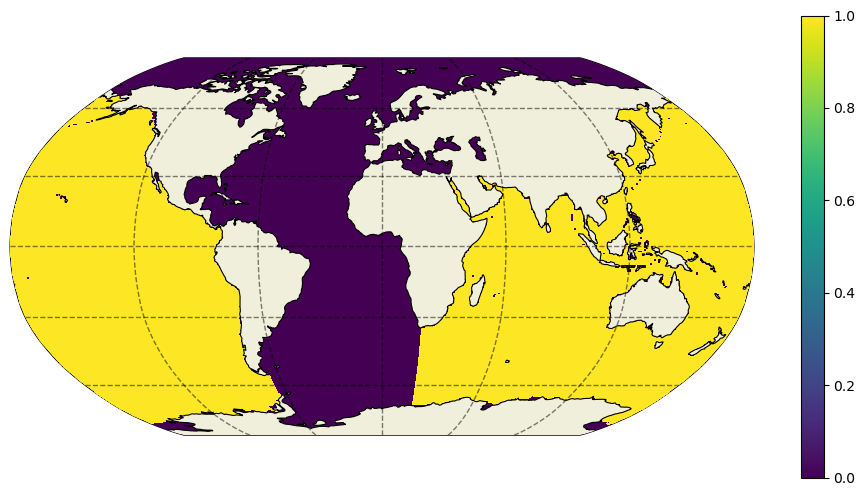

In [4]:
plt.figure(figsize = (12, 6))
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, pac_ind_ext,
                              projection_type = 'robin', cmap = 'viridis',
                              user_lon_0 = 0, show_colorbar = True);

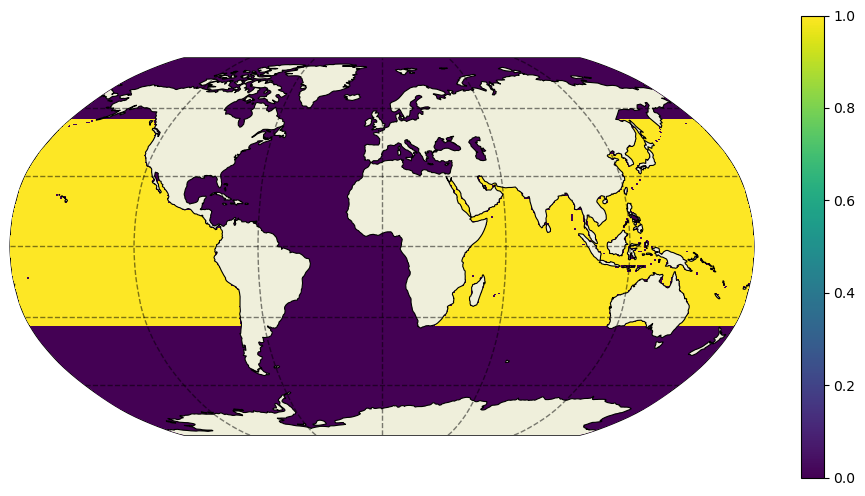

In [5]:
plt.figure(figsize = (12, 6))
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, solly_indo_pacific,
                              projection_type = 'robin', cmap = 'viridis',
                              user_lon_0 = 0, show_colorbar = True);

# Calculating bolus streamfunction for 30S sections

In [18]:
# Load the data and the native geometry grid
geom_fp = os.path.join(drive_base_path, 'utility_files/GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')
ecco_grid = xr.open_dataset(geom_fp)

bolus_native_grid = os.path.join(drive_base_path, 'solodoch_data_full/ECCO_L4_BOLUS_LLC0090GRID_MONTHLY_V4R4')
nc_files = (os.path.join(bolus_native_grid, '*.nc'))
nc_ds = xr.open_mfdataset(nc_files, data_vars = 'minimal', coords = 'minimal', compat = 'override')

ds = xr.merge((nc_ds, ecco_grid))
ds

<xarray.Dataset>
Dimensions:    (tile: 13, j_g: 90, i_g: 90, k_p1: 51, k_l: 50, j: 90, i: 90,
                time: 312, k: 50, nb: 4, k_u: 50, nv: 2)
Coordinates: (12/24)
    XG         (tile, j_g, i_g) float32 -115.0 -115.0 -115.0 ... -102.9 -109.0
    Zp1        (k_p1) float32 0.0 -10.0 -20.0 ... -5.678e+03 -6.134e+03
    Zl         (k_l) float32 0.0 -10.0 -20.0 ... -5.244e+03 -5.678e+03
    YC         (tile, j, i) float32 -88.24 -88.38 -88.52 ... -88.03 -88.08 -88.1
    XC         (tile, j, i) float32 -111.6 -111.3 -110.9 ... -105.6 -111.9
    YG         (tile, j_g, i_g) float32 -88.18 -88.32 -88.46 ... -87.99 -88.02
    ...         ...
  * k_p1       (k_p1) int32 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * k_u        (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * nb         (nb) float32 0.0 1.0 2.0 3.0
  * nv         (nv) float32 0.0 1.0
  * tile       (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 1992-01-16T18:00:00 ... 2017-12-16T06:00:00
Data variables: (12/24)
    VVELSTAR   (time, k, tile, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    WVELSTAR   (time, k_l, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    UVELSTAR   (time, k, tile, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    CS         (tile, j, i) float32 ...
    SN         (tile, j, i) float32 ...
    rA         (tile, j, i) float32 ...
    ...         ...
    hFacC      (k, tile, j, i) float32 ...
    hFacW      (k, tile, j, i_g) float32 ...
    hFacS      (k, tile, j_g, i) float32 ...
    maskC      (k, tile, j, i) bool ...
    maskW      (k, tile, j, i_g) bool ...
    maskS      (k, tile, j_g, i) bool ...
Attributes: (12/63)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Gent-McWilliams Ocean Bolus Velocit...
    uuid:                            4084c7b8-4182-11eb-897d-0cc47a3f43ff
    history_json:                    [{"$schema":"https:\/\/harmony.earthdata...

In [22]:
# Calculate streamfunction over 30S and over all time periods - seperately for the two constituent basins!
latitude = -30
psi_ind = calc_meridional_stf(ds, [latitude], doFlip = True, basin_name = 'indExt', velocity_field = 'bolus')
psi_pac = calc_meridional_stf(ds, [latitude], doFlip = True, basin_name = 'pacExt', velocity_field = 'bolus')

['indExt']
get_basin_name:  ['ind', 'southChina', 'java', 'timor', 'red', 'gulf'] /Users/emiliolr/Desktop/GTC-OTP/ECCOv4-py/binary_data
load_binary_array: loading file /Users/emiliolr/Desktop/GTC-OTP/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4
shape after reading 
(13, 90, 90)
get_basin_name:  ['ind', 'southChina', 'java', 'timor', 'red', 'gulf'] /Users/emiliolr/Desktop/GTC-OTP/ECCOv4-py/binary_data
load_binary_array: loading file /Users/emiliolr/Desktop/GTC-OTP/ECCOv4-py/binary_data/basins.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 9

In [36]:
# Write to NetCDF to upload to drive
psi_ind.to_netcdf('/Users/emiliolr/Desktop/PSI_indian_bolus30S.nc')
psi_pac.to_netcdf('/Users/emiliolr/Desktop/PSI_pacific_bolus30S.nc')

# Looking at streamfunction section values

In [57]:
fp_total = os.path.join(drive_base_path, 'streamfunctions_ecco/30S/PSI_residual30S.nc')
moc_30s = xr.open_dataset(fp_total)

fp_ind_res = os.path.join(drive_base_path, 'streamfunctions_ecco/30S/PSI_indian_residual30S.nc')
fp_ind_bol = os.path.join(drive_base_path, 'streamfunctions_ecco/30S/PSI_indian_bolus30S.nc')
moc_30s_ind_res = xr.open_dataset(fp_ind_res)
moc_30s_ind_bol = xr.open_dataset(fp_ind_bol)
moc_30s_ind = moc_30s_ind_res + moc_30s_ind_bol

fp_pac_res = os.path.join(drive_base_path, 'streamfunctions_ecco/30S/PSI_pacific_residual30S.nc')
fp_pac_bol = os.path.join(drive_base_path, 'streamfunctions_ecco/30S/PSI_pacific_bolus30S.nc')
moc_30s_pac_res = xr.open_dataset(fp_pac_res)
moc_30s_pac_bol = xr.open_dataset(fp_pac_bol)
moc_30s_pac = moc_30s_pac_res + moc_30s_pac_bol

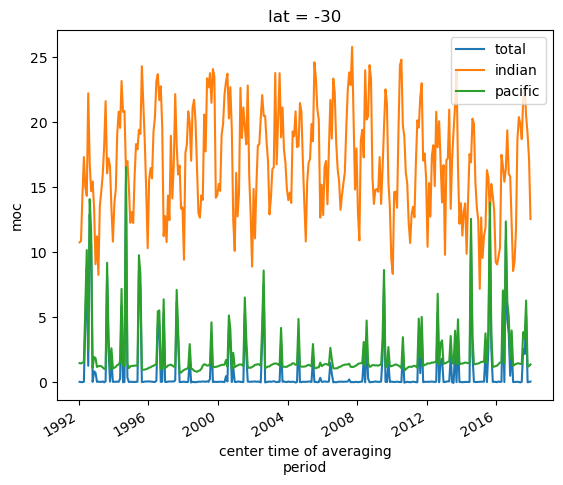

In [41]:
moc_30s.moc.plot(label = 'total')
moc_30s_ind.moc.plot(label = 'indian')
moc_30s_pac.moc.plot(label = 'pacific')

plt.legend()

# Using the two sections independently

I think in essence the total MOC at 30S should just be the sum of the Indian
and pacific `psi_moc` data variables. This has just been aggregated over the longitude dimension for each of the `indExt` and `pacExt` basin masks (which partition the longitudes for this latitude) so in principle the sum should decompose as: 

$$
\begin{align}
\Psi(y, t) &= \sum _{x=x_1}^{x_2} \sum _{z=z_1}^{z_2} v(x, y, z, t) \Delta x \Delta z \\
&= \left( \sum _{x=x_1}^{x'} \sum _{z=z_1}^{z_2} v(x, y, z, t) \Delta x \Delta z \right) +  \left( \sum _{x=x'}^{x_2} \sum _{z=z_1}^{z_2} v(x, y, z, t) \Delta x \Delta z \right) \\
&= \sum _{z=z_1}^{z_2} \left( \sum _{x = x_1}^{x'} v(x, y, z, t) \Delta x \Delta z + \sum _{x = x'}^{x_2} v(x, y, z, t) \Delta x \Delta z \right), \\
\end{align}
$$

where the inner sums are just the `psi_moc` variables for the two longitude ranges **as long as we're using a constant upper depth bound across all longitudes.**

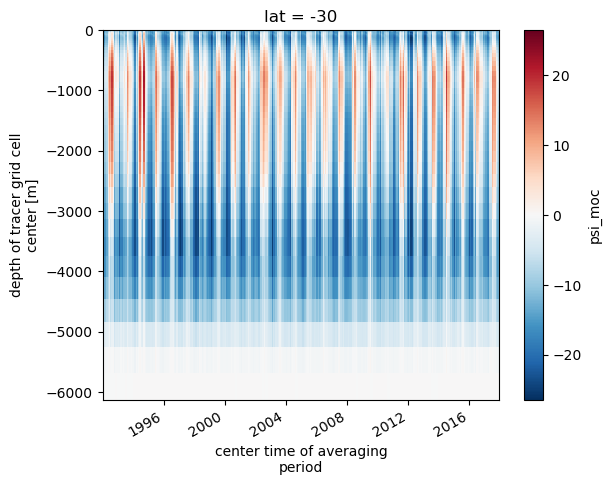

In [58]:
# Perform the above inner summation (everything in parentheses)
psi_moc_tot = moc_30s_ind.psi_moc + moc_30s_pac.psi_moc
psi_moc_tot.plot(x = 'time', y = 'Z');

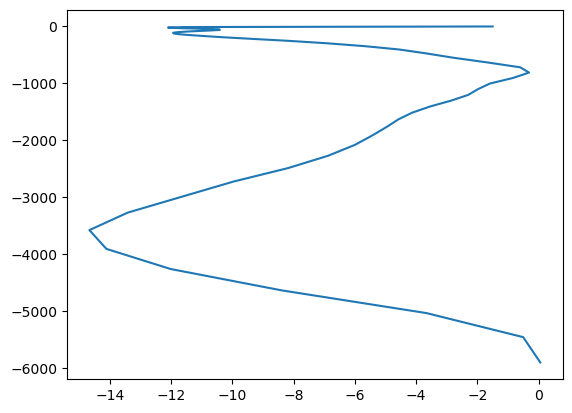

In [59]:
time_mean_psi = psi_moc_tot.mean('time')
plt.plot(time_mean_psi, time_mean_psi.Z);

In [60]:
# Find the depth where the timeseries abs value MOC is maximized
z_max = np.argmax(np.abs(psi_moc_tot.mean('time').squeeze().values))
moc_strength_tot = psi_moc_tot.isel(k = z_max).squeeze()
print('Maximizing layer:', z_max)

Maximizing layer: 43


In [61]:
# Reading in Sharan's calculations for comparison
sharan_30s_fp = os.path.join(drive_base_path, 'ecco_data_minimal/30S_moc_depth.pickle')
with open(sharan_30s_fp, 'rb') as f:
  sharan_30s = pickle.load(f)

print('Lat-lon MOC has shape', sharan_30s.shape)

Lat-lon MOC has shape (3, 312)


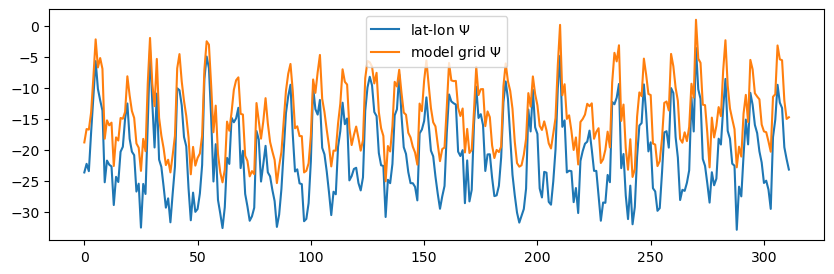

In [70]:
grid_streamfunction = moc_strength_tot.squeeze().values
lat_lon_streamfunction = sharan_30s[1, : ]

plt.figure(figsize = (10, 3))

plt.plot(lat_lon_streamfunction, label = 'lat-lon $\Psi$')
plt.plot(grid_streamfunction, label = 'model grid $\Psi$')

plt.legend();

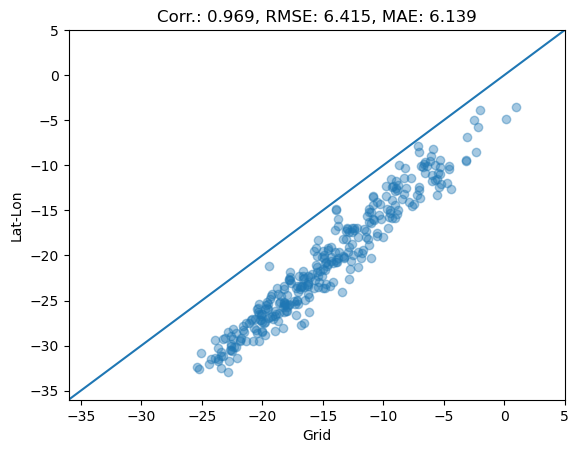

In [72]:
plt.scatter(grid_streamfunction, lat_lon_streamfunction, alpha = 0.4)
plt.axline((0, 0), slope = 1)

limits = (-36, 5)
plt.xlim(limits)
plt.ylim(limits)

plt.xlabel('Grid')
plt.ylabel('Lat-Lon')

corr_coef = np.corrcoef(grid_streamfunction, lat_lon_streamfunction)[0, 1]
rmse_obs = rmse(grid_streamfunction, lat_lon_streamfunction)
mae_obs = mae(grid_streamfunction, lat_lon_streamfunction)

plt.title(f'Corr.: {round(corr_coef, 3)}, RMSE: {round(rmse_obs, 3)}, MAE: {round(mae_obs, 3)}');

In [67]:
# Checking error when bolus isn't added in
psi_moc_tot_res = moc_30s_ind_res.psi_moc + moc_30s_pac_res.psi_moc
z_max_res = np.argmax(np.abs(psi_moc_tot_res.mean('time').squeeze().values))
moc_strength_tot_res = psi_moc_tot_res.isel(k = z_max_res).squeeze()
print('Maximizing layer:', z_max_res)

grid_streamfunction_res = moc_strength_tot_res.squeeze().values

corr_coef_res = np.corrcoef(grid_streamfunction_res, lat_lon_streamfunction)[0, 1]
rmse_obs_res = rmse(grid_streamfunction_res, lat_lon_streamfunction)
mae_obs_res = mae(grid_streamfunction_res, lat_lon_streamfunction)

print('Corr.:', round(corr_coef_res, 3))
print('RMSE:', round(rmse_obs_res, 3))
print('MAE:', round(mae_obs_res, 3))

Maximizing layer: 43
Corr.: 0.964
RMSE: 8.637
MAE: 8.407
